# Tactical Asset Allocation

In [23]:
%%capture
%reload_ext autoreload
%autoreload 2
%cd ..
%cd src

In [24]:
from pytaa.tools.data import get_strategy_price_data
from pytaa.strategy.static import STRATEGIES
from pytaa.strategy.strategies import StrategyPipeline
from pytaa.strategy.signals import Signal
from pytaa.backtest.positions import (
    EqualWeights, RiskParity, vigilant_allocation, kipnis_allocation, aqr_trend_allocation
)
from pytaa.backtest.performance import Tearsheet
from pytaa.backtest.returns import Backtester


import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

In [25]:
start, end = "2011-01-01", "2023-05-01"
rebalance_dates = pd.bdate_range(start, end, freq="BM")

pipeline = StrategyPipeline(STRATEGIES)
data = get_strategy_price_data(pipeline, start, end).dropna()

In [26]:
all_strategies = []

# ivy
strategy = pipeline.ivy
strategy_data = data[strategy.risk_assets]
signals = Signal(strategy_data).sma_crossover(10).dropna()

weights = signals.apply(lambda x: np.where(x > 0, strategy.weights[0], 0))
weights.loc[:, strategy.safe_assets] = 1 - weights.sum(axis=1)
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# benchmark strategies
assets = ["SPY", "AGG", "IEF", "GLD", "EEM"]
returns = data.pct_change().dropna().loc[:, assets]

ew = EqualWeights(assets, rebalance_dates).weights
rp = RiskParity(assets, rebalance_dates, returns).weights
all_strategies.append([ew, rp])

# robust asset allocation
strategy = pipeline.raab
strategy_data = data[strategy.get_tickers()]
signal_1 = Signal(strategy_data).classic_momentum(end=0).dropna()
signal_2 = Signal(strategy_data).sma_crossover(12, False).dropna()
cond_1 = np.where(signal_1[strategy.risk_assets].gt(signal_1[strategy.safe_assets].values), 1, 0)
cond_2 = np.where(strategy_data.reindex(signal_2.index) > signal_2, 1, 0)[:,:-1]
final_signal = cond_1 + cond_2
cash = np.atleast_2d(len(strategy.risk_assets) - np.sum(final_signal / 2, 1)).T
idx, cols = signal_1.index, signal_1.columns
weights = pd.DataFrame(np.hstack([final_signal, cash]), index=idx, columns=cols)
weights = weights.div(weights.sum(axis=1).values.reshape(-1, 1))
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# vigilant asset allocation g12
strategy = pipeline.vaag12
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score()
args = (strategy.risk_assets, strategy.safe_assets)
weights = pd.concat([x for x in signal.apply(lambda x: vigilant_allocation(x, *args), axis=1)])
weights.index = signal.index
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# vigilant asset allocation g4
strategy = pipeline.vaag4
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score()
args = (strategy.risk_assets, strategy.safe_assets, 1, 1)
weights = pd.concat([x for x in signal.apply(lambda x: vigilant_allocation(x, *args), axis=1)])
weights.index = signal.index
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# gem dual momentum
strategy = pipeline.gdm
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).classic_momentum(start=12, end=0)
cond_1, cond_2 = signal["SPY"].ge(signal["BIL"]), signal["SPY"].ge(signal["EFA"])
spy = np.where(cond_1 & cond_2, 1, 0).reshape(-1,1)
efa = np.where(cond_1 & ~cond_2, 1, 0 ).reshape(-1,1)
agg = np.where(~cond_1, 1, 0).reshape(-1,1)
weights = pd.DataFrame(np.hstack([spy, efa, agg]), index=signal.index, columns=["SPY", "EFA", "AGG"])
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# diversified gem dual momentum
strategy = pipeline.dgdm
strategy_data = data[strategy.get_tickers()]
mom_periods = [6, 7, 8, 9, 10, 11, 12]
monthly = strategy_data.resample("BM").last()
spy, agg = np.zeros((monthly.shape[0], 1)), np.zeros((monthly.shape[0], 1))
efa = np.zeros((monthly.shape[0], 1))

for w in mom_periods:
    signal = Signal(strategy_data).classic_momentum(start=w, end=0)
    cond_1, cond_2 = signal["SPY"].ge(signal["AGG"]), signal["SPY"].ge(signal["EFA"])
    spy += np.where(cond_1 & cond_2, 1, 0).reshape(-1,1)
    efa += np.where(cond_1 & ~cond_2, 1, 0 ).reshape(-1,1)
    agg += np.where(~cond_1, 1, 0).reshape(-1,1)
idx, cols = monthly.index, monthly.columns
weights = pd.DataFrame(np.hstack([spy, efa, agg]) / len(mom_periods), index=idx, columns=cols)
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# kipnis defensive asset allocation
strategy = pipeline.kdaaa
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score().dropna()
returns = strategy_data.pct_change()
weights = kipnis_allocation(returns, signal, rebalance_dates, strategy.safe_assets, strategy.risk_assets, strategy.safe_assets)
weights.columns.name, weights.index.name = "ID", "Date"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# trend is our friend
strategy = pipeline.tiof
strategy_data = data[strategy.get_tickers()]
returns = strategy_data.pct_change()
signal = Signal(strategy_data).sma_crossover(lookback=10)
weights = aqr_trend_allocation(returns, signal, rebalance_dates, strategy.risk_assets, "BIL")
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# concat all strats
all_strategies = reduce(lambda x, y: x.join(y, how="outer"), all_strategies).fillna(0)

In [27]:
bt = Backtester(all_strategies, "USD")
port_total_returns = bt.run(return_type="total")
port_total_returns.add(1).cumprod().tail()

,IVY,EW,RP,RAAB,VAAG12,VAAG4,GDM,DGDM,KDAAA,TIOF
Date,,,,,,,,,,
2022-12-30,1.754711,1.524680,1.247961,1.626827,1.346247,1.277291,2.285366,2.376953,1.187843,1.516681
2023-01-31,1.759507,1.602311,1.304842,1.681250,1.349926,1.280782,2.351813,2.557539,1.224180,1.520827
2023-02-28,1.732300,1.535189,1.253790,1.631445,1.297387,1.250530,2.289317,2.490656,1.168261,1.504022
2023-03-31,1.749544,1.594774,1.298774,1.669806,1.302849,1.255795,2.338496,2.545803,1.205151,1.517309
2023-04-28,1.758973,1.595912,1.299071,1.683962,1.305324,1.293195,2.339930,2.557972,1.217450,1.521707


In [28]:
port_price_returns = bt.run(return_type="price")
port_price_returns.add(1).cumprod().tail()

,IVY,EW,RP,RAAB,VAAG12,VAAG4,GDM,DGDM,KDAAA,TIOF
Date,,,,,,,,,,
2022-12-30,1.519112,1.300561,1.042491,1.355702,1.173509,1.124134,1.887710,1.934314,1.005366,1.316195
2023-01-31,1.523264,1.366781,1.090006,1.401056,1.176716,1.127206,1.942595,2.081271,1.036121,1.319792
2023-02-28,1.496750,1.308319,1.046055,1.357649,1.130919,1.100581,1.886384,2.022627,0.988792,1.301573
2023-03-31,1.507242,1.356866,1.081661,1.387256,1.132522,1.102142,1.922247,2.063128,1.017911,1.309066
2023-04-28,1.512155,1.356616,1.080596,1.396586,1.132059,1.134965,1.918581,2.068534,1.027829,1.308929


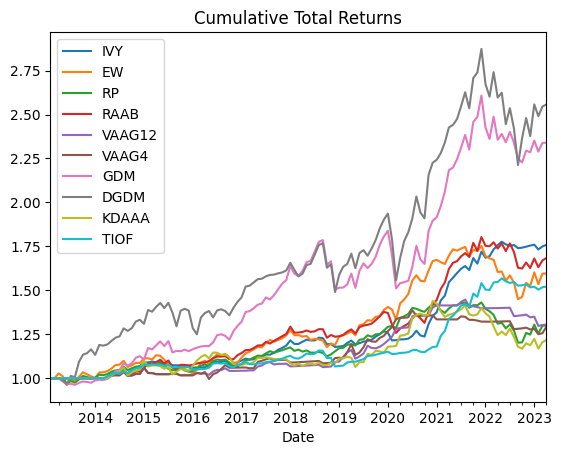

In [30]:
port_total_returns[port_total_returns.index >= "2013-02-01"].add(1).cumprod().plot(title="Cumulative Total Returns");

In [31]:
Tearsheet(port_total_returns[port_total_returns.index >= "2013-02-01"]).summary(ann_factor=12).round(2)

,IVY,EW,RP,RAAB,VAAG12,VAAG4,GDM,DGDM,KDAAA,TIOF
#obs,123.00,123.00,123.00,123.00,123.00,123.00,123.00,123.00,123.00,123.00
#years,10.16,10.16,10.16,10.16,10.16,10.16,10.16,10.16,10.16,10.16
Total Return,0.76,0.60,0.30,0.68,0.31,0.29,1.34,1.56,0.22,0.52
Annual. Return,0.06,0.05,0.03,0.05,0.03,0.03,0.09,0.10,0.02,0.04
Volatility,0.05,0.08,0.05,0.06,0.04,0.05,0.11,0.14,0.07,0.05
MaxDD,-0.04,-0.17,-0.16,-0.10,-0.10,-0.10,-0.18,-0.23,-0.19,-0.08
Skewness,0.73,-0.04,-0.27,-0.37,0.05,-0.04,-0.68,-0.49,0.07,0.99
Kurtosis,5.63,3.37,4.67,4.05,6.80,5.87,5.59,4.31,4.31,8.47
Sharpe Ratio,1.12,0.62,0.50,0.83,0.61,0.55,0.80,0.73,0.31,0.89
StdErr,0.30,0.32,0.32,0.33,0.32,0.32,0.35,0.34,0.31,0.29
